# SGDRegressor Training Notebook
This notebook contains all the code to train two SGDRegressor models not using and using one hot encoded year data as well as performance evaluation and SHAP feature importance exploration.

In [1]:
# Import block for all packages used in this notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import (
    make_pipeline,
)
from sklearn.preprocessing import (
    StandardScaler,
)

## Read Data

In [28]:
file_format = "svg"
"""
Read in our targets and features from preprocessed data. We read in weather and array fraction datat seperately from dates to simplity training models with and without 
year data.
"""
targets = np.ravel(
    pd.read_csv(
        "../data/prepro_data.csv",
        usecols=["rateUncorr"],
    ).to_numpy()
)

features = pd.read_csv(
    "../data/prepro_data.csv",
    usecols=[
        "arrayFraction",
        "temperature",
        "pressure",
        "density",
        "density2HoursBefore",
    ],
)
dates = pd.read_csv(
    "../data/prepro_data.csv",
    usecols=[
        "year_2013",
        "year_2014",
        "year_2015",
        "year_2016",
        "year_2017",
        "year_2018",
        "year_2019",
        "year_2020",
    ],
)
# used for making visualizations
years = np.ravel(
    pd.read_csv(
        "../data/prepro_data.csv",
        usecols=["year"],
    ).to_numpy()
)
features_onehot = pd.concat([features, dates], axis=1)
# Train/test split and scaling, will be used for performance evaluation and SHAP feature importance
(
    features_train_onehot,
    features_test_onehot,
    targets_train_onehot,
    targets_test_onehot,
) = train_test_split(features_onehot, targets, test_size=0.3, random_state=42)

features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.3, random_state=42
)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(features_train)
features_train_scale = scaler.transform(features_train)
features_test_scale = scaler.transform(features_test)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(features_train_onehot)
features_train_onehot_scale = scaler.transform(features_train_onehot)
features_test_onehot_scale = scaler.transform(features_test_onehot)

In [3]:
features_onehot.describe()

arrayFraction    temperature       pressure        density  \
count  221823.000000  221823.000000  221823.000000  221823.000000   
mean       98.914714      11.719636     862.067789       1.052687   
std         1.297423       9.427390       4.045152       0.028082   
min        90.000000     -15.570000     843.833333       0.993300   
25%        98.700000       4.800500     859.433333       1.030000   
50%        99.300000      11.626667     862.033333       1.051000   
75%        99.600000      18.516667     864.700000       1.074000   
max       100.000000      38.423333     881.000000       1.134000   

       density2HoursBefore      year_2013      year_2014      year_2015  \
count        221823.000000  221823.000000  221823.000000  221823.000000   
mean              1.055390       0.117017       0.110872       0.099692   
std               0.037007       0.321441       0.313974       0.299590   
min               0.957500       0.000000       0.000000       0.000000   
25%               1.028333       0.000000       0.000000       0.000000   
50%               1.054667       0.000000       0.000000       0.000000   
75%               1.081333       0.000000       0.000000       0.000000   
max               1.178667       1.000000       1.000000       1.000000   

           year_2016      year_2017      year_2018      year_2019  \
count  221823.000000  221823.000000  221823.000000  221823.000000   
mean        0.127011       0.136338       0.149755       0.116597   
std         0.332986       0.343148       0.356831       0.320941   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

           year_2020  
count  221823.000000  
mean        0.142717  
std         0.349785  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [4]:
features.describe()

arrayFraction    temperature       pressure        density  \
count  221823.000000  221823.000000  221823.000000  221823.000000   
mean       98.914714      11.719636     862.067789       1.052687   
std         1.297423       9.427390       4.045152       0.028082   
min        90.000000     -15.570000     843.833333       0.993300   
25%        98.700000       4.800500     859.433333       1.030000   
50%        99.300000      11.626667     862.033333       1.051000   
75%        99.600000      18.516667     864.700000       1.074000   
max       100.000000      38.423333     881.000000       1.134000   

       density2HoursBefore  
count        221823.000000  
mean              1.055390  
std               0.037007  
min               0.957500  
25%               1.028333  
50%               1.054667  
75%               1.081333  
max               1.178667

In [5]:
years

array([2013, 2013, 2013, ..., 2020, 2020, 2020], shape=(221823,))

## Hyperparameters

In [6]:
# 2 layers of cross validation for nested cross validated hyperparameter grid search
inner_cv = KFold(n_splits=3, shuffle=True, random_state=10)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=101)
# The standard model we will optimize
piped_model = make_pipeline(
    StandardScaler(),
    SGDRegressor(early_stopping=True, random_state=10),
)
# SGDRegressor hyperparameters we will optimize
parameters = {
    "sgdregressor__loss": ["squared_error", "huber"],
    "sgdregressor__penalty": ["l2", "l1", "elasticnet", None],
    "sgdregressor__alpha": [
        0.00001,
        0.0001,
        0.001,
    ],
    "sgdregressor__l1_ratio": [0.1, 0.5, 1],
    "sgdregressor__epsilon": [0.1, 0.5, 1, 5],
}
# Scoring metrics
scoring = [
    "neg_mean_absolute_error",
    "neg_root_mean_squared_error",
]

## SGDRegressor Without Time Data

In [7]:
# Hyperparameter grid search
model = GridSearchCV(
    piped_model,
    parameters,
    cv=outer_cv,
    verbose=2,
    n_jobs=-1,
    return_train_score=True,
    scoring=scoring[0],
)

In [8]:
model.fit(features, targets)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor_

GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor',
                                        SGDRegressor(early_stopping=True,
                                                     random_state=10))]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [1e-05, 0.0001, 0.001],
                         'sgdregressor__epsilon': [0.1, 0.5, 1, 5],
                         'sgdregressor__l1_ratio': [0.1, 0.5, 1],
                         'sgdregressor__loss': ['squared_error', 'huber'],
                         'sgdregressor__penalty': ['l2', 'l1', 'elasticnet',
                                                   None]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [9]:
print("Best params, best score:", f"{model.best_score_:.4f}", model.best_params_)

Best params, best score: -10.8827 {'sgdregressor__alpha': 0.0001, 'sgdregressor__epsilon': 1, 'sgdregressor__l1_ratio': 0.5, 'sgdregressor__loss': 'huber', 'sgdregressor__penalty': 'elasticnet'}


In [10]:
# Nested cross validated hyperparameter search
nested_model = GridSearchCV(
    piped_model,
    parameters,
    cv=inner_cv,
    verbose=2,
    n_jobs=2,
    return_train_score=True,
    scoring=scoring[0],
)
nested_score = cross_val_score(
    nested_model,
    X=features,
    y=targets,
    cv=outer_cv,
    # verbose=3,
    n_jobs=-1,
    scoring=scoring[0],
)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.7s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579

[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.6s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  17.6s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  17.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  17.6s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.7s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.8s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.8s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregresso

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.7s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.7s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.8s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  17.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregres

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__p

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.0s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.4s
[CV] END sgdregressor__alpha

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.5s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.2s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.4s
[CV] END sgdregressor__alpha

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__pen

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, s

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.5s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdre

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error,

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.7s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total tim

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.8s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total tim

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; tot

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticne

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  17.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.8s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.0s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgd

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total tim

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total tim

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=sq

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.1s
[CV] END sgdregressor_

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.6s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=   3.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.6s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.1s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.2s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.7s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.2s
[CV] END sgdregressor_

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.5s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=   3.4s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.0s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.3s
[CV] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=   3.1s
[CV] END sgd

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  18.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  13.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  13.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  15.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  15.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  13.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  13.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  15.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  13.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdre

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   9.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   9.0s
[CV] END sgdregressor__alp

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  22.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total tim

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.9s
[CV] END sgd

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   9.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   9.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   7.9s
[CV] END sgdregressor__alpha=0.001, 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   8.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  22.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  22.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  19.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  22.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  21.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregres

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   2.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  16.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1; total time=   0.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=   3.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  18.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.0s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   2.9s
[CV] END sgdregressor__alpha

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  17.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  15.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   3.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=   3.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   3.9s
[CV] END sgdregresso

In [11]:
print(
    f"Nested CV MAE (mean ± std): {-nested_score.mean():.5f} ± {nested_score.std():.6f}"
)

Nested CV MAE (mean ± std): 10.88286 ± 0.018675


In [12]:
print(
    f"Final model MAE (mean ± std): {-model.best_score_.mean():.5f} ± {nested_score.std():.6f}"
)

Final model MAE (mean ± std): 10.88275 ± 0.018675


### Model Performance Evaluation

Test MAE: 10.81732
Test R²: 0.78798


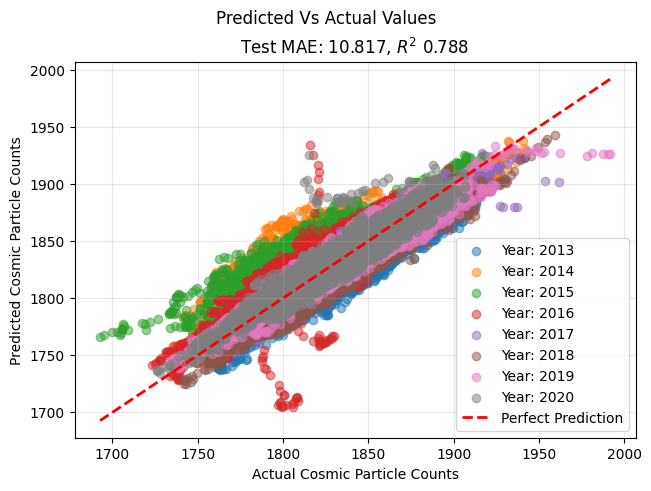

In [29]:
# Create model with your best parameters
best_model = SGDRegressor(
    early_stopping=True,
    loss="huber",
    alpha=0.0001,
    epsilon=1,
    l1_ratio=0.5,
    penalty="elasticnet",
    random_state=10,
)
# Train the model
best_model.fit(features_train_scale, targets_train)
# Make predictions on test set
y_pred = best_model.predict(features_test_scale)
# Calculate test performance
test_mae = mean_absolute_error(targets_test, y_pred)
test_r2 = r2_score(targets_test, y_pred)
print(f"Test MAE: {test_mae:.5f}")
print(f"Test R²: {test_r2:.5f}")
"""
Generate plot comparing the predicted uncorrected scaler rate vs the actual scaler rate. 
Grouped by year to see if certain years are performing worse than others
"""
fig, ax = plt.subplots(layout="constrained")
# Logic to group shuffled features to the correct year
for year in np.unique(years):
    year_idxs = np.argwhere(
        year == years
    )  # find indexs of current year in original dataset
    idxs = np.isin(features_test_scale.index, year_idxs).nonzero()[
        0
    ]  # find the new index of instances in shuffled test set
    ax.scatter(
        targets_test[idxs], y_pred[idxs], alpha=0.5, label=f"Year: {year}"
    )  # Scatter plot of predictions vs actual
# Perfect prediction line (y=x)
min_val = min(targets_test.min(), y_pred.min())
max_val = max(targets_test.max(), y_pred.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)

ax.set_xlabel("Actual Cosmic Particle Counts")
ax.set_ylabel("Predicted Cosmic Particle Counts")
ax.set_title(f"Test MAE: {test_mae:.3f}, $R^{2}$ {test_r2:.3f}")
fig.suptitle("Predicted Vs Actual Values")
# Add grid, legend and save plot to plots directory
ax.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(
    f"../plots/pred_vs_act.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

### SHAP Exploration

In [14]:
# Liner explaner used in force plot
explainer = shap.explainers.Linear(best_model, features_test_scale)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(features_test_scale)
# General explaner used in beeswar and bar plots
explainer_2 = shap.Explainer(best_model, features_test_scale)
shap_values_2 = explainer(features_test_scale)

In [15]:
shap.initjs()
shap.plots.force(
    explainer.expected_value,
    shap_values[:1000],
    features=features_test_scale.to_numpy()[:1000],
    feature_names=features_test_scale.columns,
)

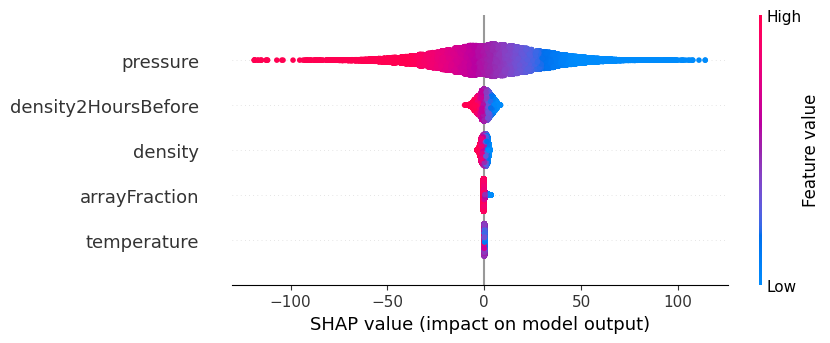

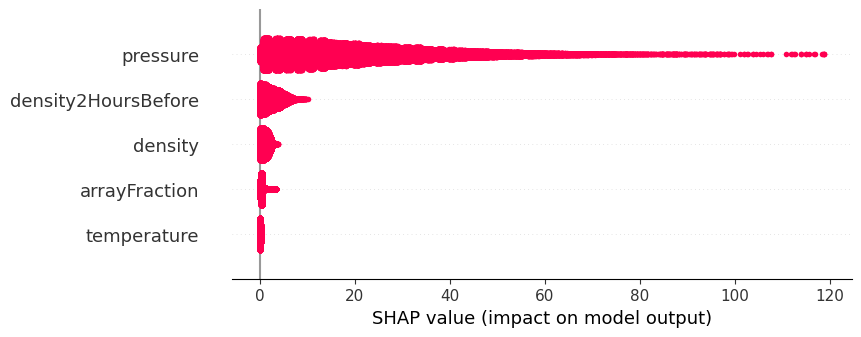

In [30]:
shap.plots.beeswarm(
    shap_values_2, max_display=40, order=shap_values_2.abs.max(0), show=False
)
plt.savefig(
    f"../plots/shap_beeswarm.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)
shap.plots.beeswarm(
    shap_values_2.abs,  # Beeswarm plot using absolute value of SHAP values
    color="shap_red",
    max_display=40,
    order=shap_values_2.abs.max(
        0
    ),  # sort SHAP values by the largest absolute value for that feature
    show=False,
)
plt.savefig(
    f"../plots/shap_beeswarm_abs.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

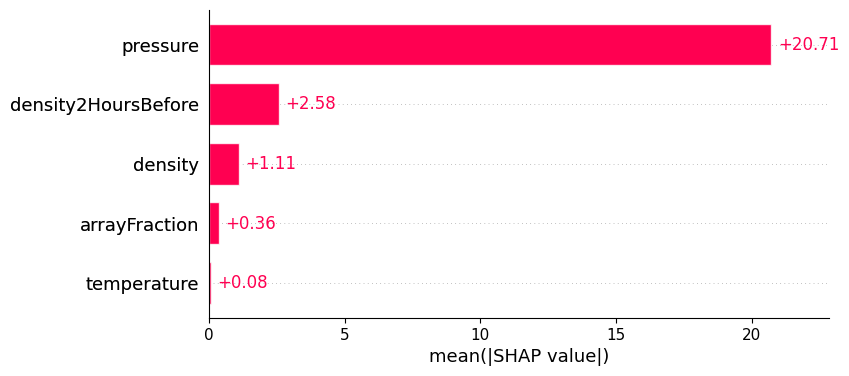

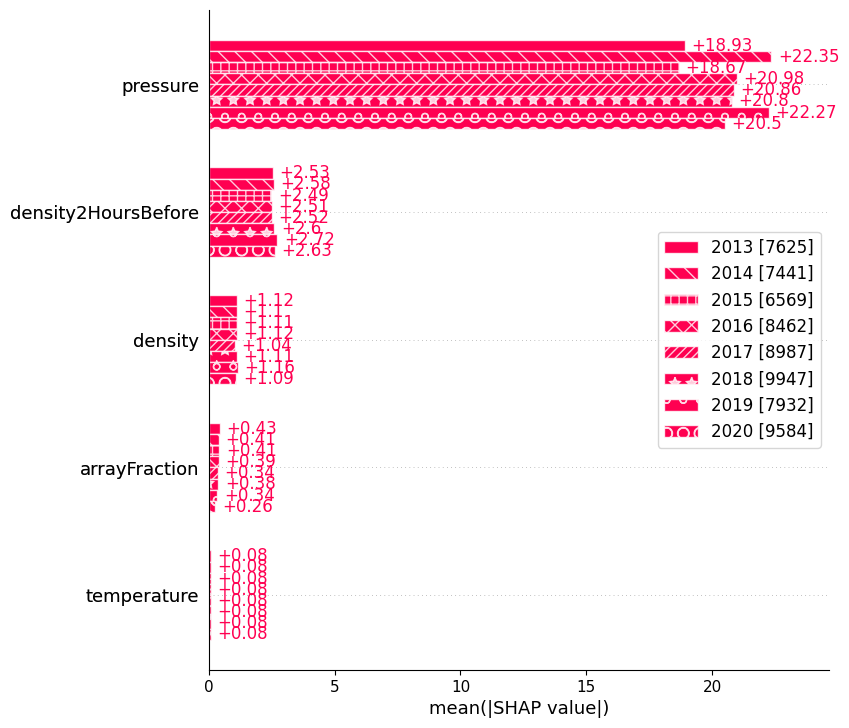

In [31]:
# Label each shap value with the year it corresponds to
cohort_year = list(range(len(shap_values_2)))
for year in np.unique(years):
    year_idxs = np.argwhere(year == years)
    idxs = np.isin(features_test_scale.index, year_idxs).nonzero()[0]
    for i in idxs:
        cohort_year[i] = str(year)
# Plot that shows the global feature importance
shap.plots.bar(shap_values_2, show=False)
plt.savefig(
    f"../plots/shap_bar.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)
# Feature importance grouped by the year the instance is from
shap.plots.bar(shap_values_2.cohorts(cohort_year).abs.mean(0), show=False)
plt.savefig(
    f"../plots/shap_bar_clus.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

## SGDRegressor With Onehot Encoded Time Data

In [18]:
# Hyperparameter grid search
model_onehot = GridSearchCV(
    piped_model,
    parameters,
    cv=outer_cv,
    verbose=2,
    n_jobs=-1,
    return_train_score=True,
    scoring=scoring[0],
)

In [19]:
model_onehot.fit(features_onehot, targets)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.4s
[CV] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  48.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  37.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  50.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  50.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV]

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  47.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  47.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  11.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  46.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  47.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=  11.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  50.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  46.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  37.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  37.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  36.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  37.1s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  39.0s
[CV] END s

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  48.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   6.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   5.8s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  37.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  38.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  48.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   6.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  49.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   6.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=  50.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  49.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1; total time=   5.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=   5.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet; total time=   0.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error,

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.3s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None; total time=   0.4s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=   4.9s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=   5.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=   5.2s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None; total time=  

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet; total time=  52.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   4.5s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   4.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   4.7s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   4.6s
[CV] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2; total time=   4.6s
[CV] END sgdregressor_

GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor',
                                        SGDRegressor(early_stopping=True,
                                                     random_state=10))]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [1e-05, 0.0001, 0.001],
                         'sgdregressor__epsilon': [0.1, 0.5, 1, 5],
                         'sgdregressor__l1_ratio': [0.1, 0.5, 1],
                         'sgdregressor__loss': ['squared_error', 'huber'],
                         'sgdregressor__penalty': ['l2', 'l1', 'elasticnet',
                                                   None]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [20]:
print(
    "Best params, best score:",
    f"{model_onehot.best_score_:.4f}",
    model_onehot.best_params_,
)

Best params, best score: -7.8748 {'sgdregressor__alpha': 0.0001, 'sgdregressor__epsilon': 1, 'sgdregressor__l1_ratio': 0.1, 'sgdregressor__loss': 'huber', 'sgdregressor__penalty': 'l1'}


In [21]:
# Nested cross validated hyperparameter search
nested_model = GridSearchCV(
    piped_model,
    parameters,
    cv=inner_cv,
    verbose=3,
    n_jobs=2,
    return_train_score=True,
    scoring=scoring[0],
)
nested_score_onehot = cross_val_score(
    nested_model,
    X=features_onehot,
    y=targets,
    cv=outer_cv,
    # verbose=3,
    n_jobs=-1,
    scoring=scoring[0],
)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsi

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.496) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579

[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.465) total time=  20.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.637) total time=  20.3s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.674) total time=  20.3s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.583) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579

[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.539) total time=  21.3s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.541) total time=  21.4s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.718) total time=  21.4s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.614) total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.639) total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.315) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579

[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.152) total time=  20.1s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.125) total time=  20.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.229) total time=  20.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.313) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.613) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579

[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.673) total time=  23.9s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.583) total time=  23.8s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.636) total time=  23.7s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.716) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.499) total time=  23.1s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.640) total time=  22.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.463) total time=  23.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.537) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.540) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.318) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.153) total time=  23.3s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.314) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.132) total time=  23.4s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.234) total time=  23.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.614) total time=  22.9s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.637) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.718) total time=  22.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.674) total time=  22.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.583) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.465) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.496) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.541) total time=  23.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.639) total time=  24.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.539) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.313) total time=  22.9s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.152) total time=  22.7s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.315) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.125) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.229) total time=  23.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  20.3s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  18.8s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  18.7s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.8s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.945) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  19.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, scor

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  21.0s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.674) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.614) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.718) total time=  20.8s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.637) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.583) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.496) total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.465) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.541) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.639) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.539) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.315) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.125) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.152) total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.313) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.229) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.613) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.716) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.583) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.636) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.673) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.499) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.640) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.537) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.463) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.540) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.314) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.318) total time=  24.0s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.132) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.234) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.153) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.673) total time=  22.6s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.637) total time=  23.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.613) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.717) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.583) total time=  23.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.498) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.464) total time=  23.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.639) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.541) total time=  23.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.538) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.153) total time=  22.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.314) total time=  22.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.128) total time=  23.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.315) total time=  22.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.231) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  19.0s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.9s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.91

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.917, test=-7.955) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.93

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.917, test=-7.955) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(tra

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.941, test=-7.903) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  19.4s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.92

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.674) total time=  20.3s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.614) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.637) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.718) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.583) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.496) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.465) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.639) total time=  21.0s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.541) total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.539) total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.152) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.315) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.125) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.313) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.229) total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.613) total time=  23.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.716) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.636) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.583) total time=  24.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.673) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.537) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.499) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.640) total time=  23.3s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.463) total time=  22.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.540) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.314) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.132) total time=  22.7s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.318) total time=  23.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.234) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.153) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.673) total time=  23.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.613) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.716) total time=  23.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.636) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.583) total time=  22.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.499) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.640) total time=  24.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.463) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.540) total time=  23.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.537) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.314) total time=  22.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.153) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.318) total time=  22.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.132) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.234) total time=  22.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.9s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.917, test=-7.955) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.42

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.917, test=-7.955) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.920, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  20.9s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.847) total time=   3.7s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.885, test=-7.844) total time=   3.7s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.869, test=-7.895) total time=   3.8s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.887, test=-7.846) total time

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  21.4s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.878, test=-7.872) total time=   3.7s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  21.2s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.874, test=-7.888) total time=   3.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  20.8s
[CV 1/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.866, test=-7.902) total time=   4.1s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.862, test=-7.894) total time=   3.7s
[CV 2/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.886, test=-7.858) total time=   3.6s
[CV 3/3] END sgdregressor__alpha=1e-05, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.867, test=-7.886) total time

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.598) total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.501) total time=  21.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.648) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.696) total time=  20.3s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.543) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.469) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.656) total time=  21.1s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.620) total time=  21.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.547) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.564) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.301) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.184) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.332) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.147) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.244) total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.587) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.624) total time=  26.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.676) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.609) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.553) total time=  25.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.494) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.534) total time=  24.3s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.460) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.663) total time=  24.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.539) total time=  25.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.293) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.212) total time=  25.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.179) total time=  24.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.360) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.268) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.597) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.694) total time=  23.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.647) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.619) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.564) total time=  23.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.503) total time=  24.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.657) total time=  23.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.542) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.468) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.546) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.300) total time=  23.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.335) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.152) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.186) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  21.0s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.248) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  20.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.9s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.917, test=-7.955) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.879) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.945) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, sco

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.929, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.895, test=-7.944) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, sco

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  19.3s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  21.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.924, test=-7.904) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.937, test=-7.940) total time=   0.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.598) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.696) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.620) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.648) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.564) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.501) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.656) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.543) total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.469) total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.547) total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.301) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.332) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.147) total time=  20.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.184) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.244) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.609) total time=  24.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.587) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.624) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.676) total time=  26.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.553) total time=  25.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.494) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.460) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.663) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.534) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.539) total time=  25.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.179) total time=  24.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.293) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.212) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.360) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.268) total time=  25.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.593) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.686) total time=  23.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.615) total time=  23.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.638) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.560) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.662) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.501) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.538) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.464) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.543) total time=  24.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.297) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.348) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.165) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.195) total time=  26.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.258) total time=  24.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  19.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.8s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.917, test=-7.955) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.950) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  18.1s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.917, test=-7.955) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, sco

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.929, test=-7.945) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.941, test=-7.903) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(trai

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  18.8s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  19.3s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  21.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  21.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.395, test=-432.598) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.422, test=-432.696) total time=  20.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.434, test=-432.620) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.389, test=-432.648) total time=  20.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.415, test=-432.564) total time=  20.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.392, test=-432.656) total time=  21.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.429, test=-432.501) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.421, test=-432.543) total time=  21.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.407, test=-432.547) total time=  21.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.517, test=-432.469) total time=  21.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.542, test=-432.301) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.561, test=-432.332) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.628, test=-432.147) total time=  20.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.581, test=-432.184) total time=  19.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-432.536, test=-432.244) total time=  21.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.609) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.587) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.624) total time=  25.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.553) total time=  25.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.676) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.494) total time=  24.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.460) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.663) total time=  24.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.534) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.539) total time=  25.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.179) total time=  24.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.293) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.212) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.268) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.360) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.587) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.676) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.609) total time=  24.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.624) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.553) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.663) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.494) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.534) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.460) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.539) total time=  27.8s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.293) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.360) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.179) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.212) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.268) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  20.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  18.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.917, test=-7.955) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  20.6s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.937, test=-7.950) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.917, test=-7.955) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__pe

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  18.4s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.945) total time=   0.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.392, test=-432.636) total time=  18.6s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  18.1s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.949, test=-7.918) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.924, test=-7.904) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.919, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, sco

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  21.0s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.881, test=-7.897) total time=   3.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  20.6s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.900, test=-7.858) total time=   3.7s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.866) total time=   3.6s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.866, test=-7.902) total time=   4.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  20.9s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.885, test=-7.912) total time=   3.6s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.877, test=-7.910) total time=   3.5s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.862, test=-7.907) total time=   4.6s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.866, test=-7.890) total

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  20.8s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-7.901, test=-7.872) total time=   3.5s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.867, test=-7.879) total time=   4.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  21.4s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.887, test=-7.845) total time=   4.3s
[CV 3/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.889, test=-7.852) total time=   4.3s
[CV 1/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-7.882, test=-7.917) total time=   4.0s
[CV 2/3] END sgdregressor__alpha=0.0001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.888, test=-7.84

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.575) total time=  26.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.597) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.613) total time=  24.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.666) total time=  26.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.509) total time=  24.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.680) total time=  24.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.475) total time=  24.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.549) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.538) total time=  26.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.554) total time=  24.3s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-927.670, test=-927.851) total time=  14.4s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-922.858, test=-923.022) total time=  14.0s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-918.008, test=-918.253) total time=  14.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.282) total time=  26.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-924.028, test=-924.252) total time=  14.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.178) total time=  26.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.229) total time=  25.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.358) total time=  26.4s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-938.623, test=-938.747) total time=  13.8s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-934.990, test=-935.069) total time=  13.5s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-942.256, test=-942.542) total time=  13.5s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.266) total time=  26.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-936.198, test=-936.325) total time=  14.1s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-941.190, test=-940.931) total time=  14.5s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-964.489, test=-964.135) total time=  13.5s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  18.6s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-919.335, test=-919.065) total time=  15.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  19.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  18.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.9s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  20.6s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.955) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.918, test=-7.946) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.936, test=-7.949) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__pen

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  19.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  21.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.946) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(tra

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  19.3s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1149.547, test=-1149.776) total time=   8.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1123.076, test=-1123.259) total time=   8.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  19.3s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1131.017, test=-1131.184) total time=   8.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  21.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.922, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(tra

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.923, test=-7.903) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.937, test=-7.940) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.920, test=-7.945) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.924, test=-7.904) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=squared_error, sgdregressor__p

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  19.4s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1134.983, test=-1135.062) total time=   8.3s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1134.975, test=-1135.102) total time=   8.3s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1151.033, test=-1150.776) total time=   8.3s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1141.567, 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  19.0s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1136.389, test=-1136.347) total time=   8.4s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1152.235, test=-1152.361) total time=   8.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1132.470, test=-1132.264) total time=   8.4s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1153.741, 

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.575) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.597) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.613) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.509) total time=  26.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.680) total time=  26.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.666) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.475) total time=  26.0s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.549) total time=  25.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.538) total time=  25.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.554) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.178) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.282) total time=  25.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.229) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.575) total time=  26.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.597) total time=  26.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.358) total time=  25.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.613) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.666) total time=  26.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.266) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.538) total time=  28.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.509) total time=  25.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.680) total time=  25.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.549) total time=  26.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.282) total time=  26.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.475) total time=  25.7s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.178) total time=  26.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.229) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.358) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.554) total time=  25.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  18.9s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.266) total time=  26.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  20.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.422, test=-432.722) total time=  18.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  20.9s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.955) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.392, test=-432.636) total time=  21.0s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.93

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.944) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.916, test=-7.955) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.94

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  18.8s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.939, test=-7.894) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.911, test=-7.901) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.415, test=-432.587) total time=  18.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  21.3s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.946) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.90

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  19.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  20.9s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.922, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.91

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  19.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  21.3s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1134.983, test=-1135.062) total time=   8.4s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1141.567, test=-1141.851) total time=   8.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1137.830, test=-1137.375) total time=   8.0s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1151.033, test=-11

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=0.5, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.536, test=-432.226) total time=  18.9s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1136.389, test=-1136.347) total time=   8.4s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1152.235, test=-1152.361) total time=   8.3s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1132.470, test=-1132.264) total time=   7.9s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-1153.741, test=-11

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.429, test=-432.509) total time=  24.0s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.392, test=-432.680) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.434, test=-432.597) total time=  25.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.395, test=-432.575) total time=  25.6s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.389, test=-432.613) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.517, test=-432.475) total time=  24.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.422, test=-432.666) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.421, test=-432.549) total time=  25.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.415, test=-432.538) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.407, test=-432.554) total time=  26.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.581, test=-432.229) total time=  23.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.542, test=-432.282) total time=  24.8s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.628, test=-432.178) total time=  24.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.434, test=-432.597) total time=  25.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.395, test=-432.575) total time=  26.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.561, test=-432.358) total time=  24.3s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.422, test=-432.666) total time=  27.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.389, test=-432.613) total time=  26.1s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-432.536, test=-432.266) total time=  24.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.415, test=-432.538) total time=  26.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.429, test=-432.509) total time=  24.9s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.392, test=-432.680) total time=  25.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.421, test=-432.549) total time=  26.0s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.628, test=-432.178) total time=  26.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.542, test=-432.282) total time=  26.8s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.517, test=-432.475) total time=  26.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.561, test=-432.358) total time=  26.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.581, test=-432.229) total time=  26.7s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.407, test=-432.554) total time=  25.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.395, test=-432.617) total time=  18.6s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.434, test=-432.640) total time=  18.6s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.389, test=-432.678) total time=  18.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-432.536, test=-432.266) total time=  27.2s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.392, test=-432.636) total time=  20.7s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.895, test=-7.944) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.912, test=-7.902) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.941, test=-7.903) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.429, test=-432.495) total time=  20.6s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.937, test=-7.900) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.955) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.895, test=-7.944) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, scor

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.934, test=-7.949) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.941, test=-7.903) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.916, test=-7.955) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.938, test=-7.894) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__pen

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.517, test=-432.464) total time=  21.0s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.929, test=-7.946) total time=   0.1s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.915, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l1;, score=(train=-7.928, test=-7.945) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.905, test=-7.930) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=elasticnet;, score=(train=-7.915, test=-7.879) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penal

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.421, test=-432.538) total time=  21.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.916, test=-7.879) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.914, test=-7.921) total time=   0.2s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=None;, score=(train=-7.929, test=-7.945) total time=   0.2s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(t

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.542, test=-432.317) total time=  19.5s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-27.897, test=-28.000) total time=   3.4s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.581, test=-432.146) total time=  19.4s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.628, test=-432.121) total time=  19.6s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-33.961, test=-33.882) total time=   3.5s


/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.407, test=-432.540) total time=  21.1s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.920, test=-7.945) total time=   0.1s
[CV 2/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.922, test=-7.902) total time=   0.1s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=squared_error, sgdregressor__penalty=l2;, score=(train=-7.937, test=-7.940) total time=   0.2s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.862,

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.1, sgdregressor__l1_ratio=1, sgdregressor__loss=huber, sgdregressor__penalty=None;, score=(train=-432.561, test=-432.310) total time=  18.8s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.890, test=-7.851) total time=   4.7s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-27.985, test=-28.111) total time=   3.5s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-28.163, test=-28.217) total time=   3.7s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.874, test=-7.889

/home/agogosha/School/UNC/Y2/S1/PHYS_448_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-22.798, test=-22.871) total time=   4.1s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l1;, score=(train=-7.862, test=-7.894) total time=   4.6s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-22.947, test=-22.879) total time=   3.9s
[CV 1/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=elasticnet;, score=(train=-22.847, test=-22.958) total time=   3.9s
[CV 3/3] END sgdregressor__alpha=0.001, sgdregressor__epsilon=0.5, sgdregressor__l1_ratio=0.1, sgdregressor__loss=huber, sgdregressor__penalty=l2;, score=(train=-34.1

In [22]:
print(
    f"Nested CV MAE (mean ± std): {-nested_score_onehot.mean():.5f} ± {nested_score_onehot.std():.6f}"
)

Nested CV MAE (mean ± std): 7.87537 ± 0.010250


In [23]:
print(
    f"Final model MAE (mean ± std): {-model_onehot.best_score_.mean():.5f} ± {nested_score_onehot.std():.6f}"
)

Final model MAE (mean ± std): 7.87483 ± 0.010250


### Model Performance Evaluation

Test MAE: 7.88204
Test R²: 0.88298


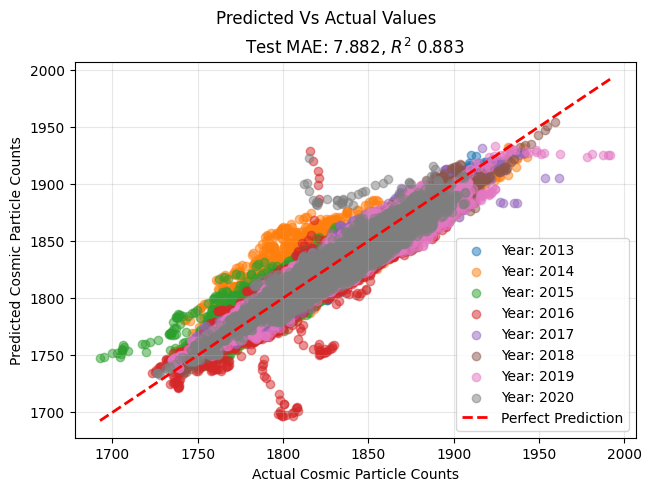

In [32]:
# Create model with your best parameters
best_model_onehot = SGDRegressor(
    early_stopping=True,
    loss="huber",
    alpha=0.0001,
    epsilon=1,
    l1_ratio=0.1,
    penalty="l1",
    random_state=10,
)
# Train the model
best_model_onehot.fit(features_train_onehot_scale, targets_train_onehot)
# Make predictions on test set
y_pred_onehot = best_model_onehot.predict(features_test_onehot_scale)
# Calculate test performance
test_mae_onehot = mean_absolute_error(targets_test_onehot, y_pred_onehot)
test_r2_onehot = r2_score(targets_test_onehot, y_pred_onehot)
print(f"Test MAE: {test_mae_onehot:.5f}")
print(f"Test R²: {test_r2_onehot:.5f}")
fig, ax = plt.subplots(layout="constrained")
# Logic to group shuffled features to the correct year
for year in np.unique(years):
    year_idxs = np.argwhere(
        year == years
    )  # find indexs of current year in original dataset
    idxs = np.isin(features_test_onehot_scale.index, year_idxs).nonzero()[
        0
    ]  # find the new index of instances in shuffled test set
    ax.scatter(
        targets_test_onehot[idxs], y_pred_onehot[idxs], alpha=0.5, label=f"Year: {year}"
    )  # Scatter plot of predictions vs actual
# Perfect prediction line (y=x)
min_val = min(targets_test_onehot.min(), y_pred.min())
max_val = max(targets_test_onehot.max(), y_pred.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)
ax.set_xlabel("Actual Cosmic Particle Counts")
ax.set_ylabel("Predicted Cosmic Particle Counts")
ax.set_title(f"Test MAE: {test_mae_onehot:.3f}, $R^{2}$ {test_r2_onehot:.3f}")
fig.suptitle("Predicted Vs Actual Values")
# Add grid, legend and save plot to plots directory
ax.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(
    f"../plots/pred_vs_act_onehot.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

### SHAP Exploration

In [25]:
# Liner explaner used in force plot
explainer_onehot = shap.explainers.Linear(best_model_onehot, features_test_onehot_scale)
expected_value_onehot = explainer_onehot.expected_value
shap_values_onehot = explainer_onehot.shap_values(features_test_onehot_scale)
# General explaner used in beeswar and bar plots
explainer_onehot_2 = shap.Explainer(best_model_onehot, features_test_onehot_scale)
shap_values_onehot_2 = explainer_onehot(features_test_onehot_scale)

In [26]:
shap.initjs()
shap.plots.force(
    explainer_onehot.expected_value,
    shap_values_onehot[:1000],
    features=features_test_onehot_scale.to_numpy()[:1000],
    feature_names=features_test_onehot_scale.columns,
)

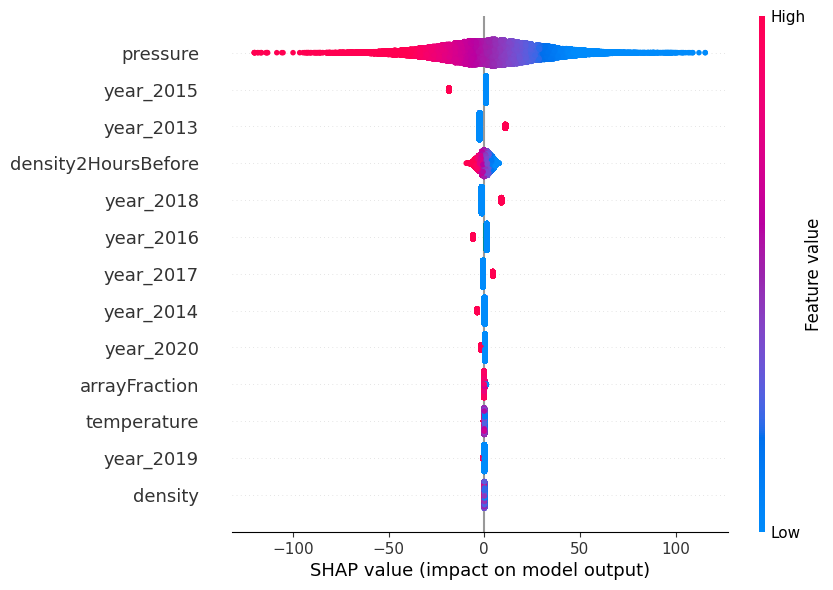

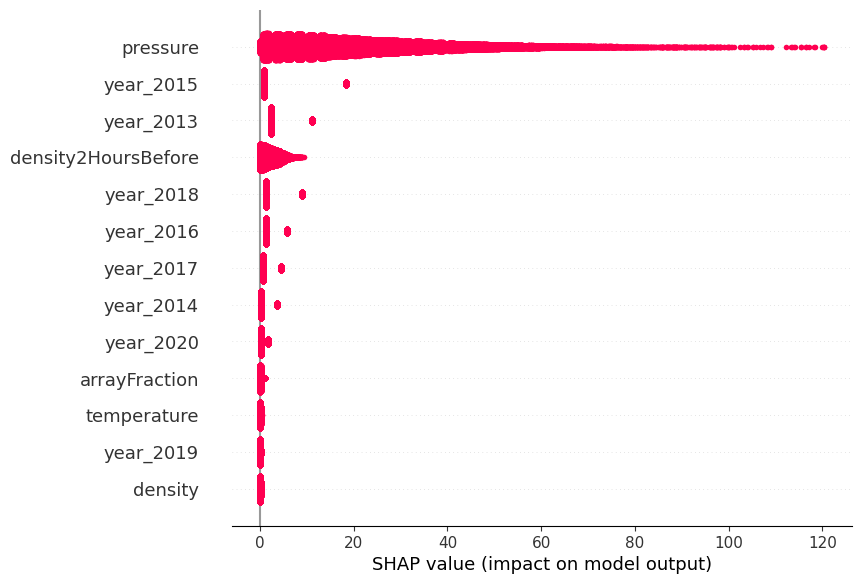

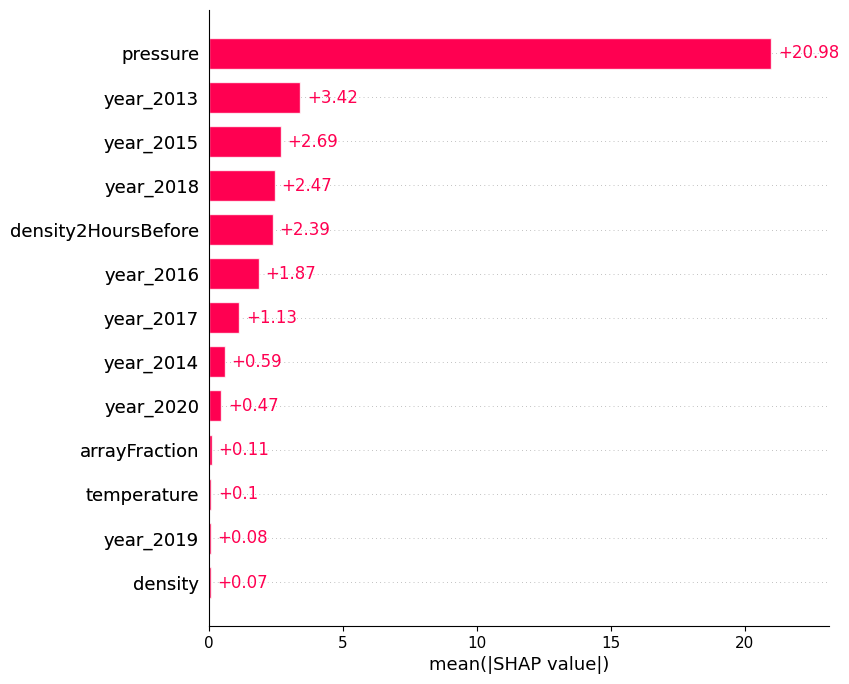

In [33]:
shap.plots.beeswarm(
    shap_values_onehot_2,
    max_display=40,
    order=shap_values_onehot_2.abs.max(0),
    show=False,
)
plt.savefig(
    f"../plots/shap_onehot_beeswarm.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

shap.plots.beeswarm(
    shap_values_onehot_2.abs,  # Beeswarm plot using absolute value of SHAP values
    color="shap_red",
    max_display=40,
    order=shap_values_onehot_2.abs.max(
        0
    ),  # sort SHAP values by the largest absolute value for that feature
    show=False,
)
plt.savefig(
    f"../plots/shap_onehot_beeswarm_abs.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)
# Plot that shows the global feature importance
shap.plots.bar(shap_values_onehot_2, max_display=16, show=False)
plt.savefig(
    f"../plots/shap_onehot_bar.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)